## Machine learning guided search for high strength high entropy refractory alloys
## Ramsey Issa and Trupti Mohanty 
## CS6350 Project 
## This notebook is for Oliynyk featurizer and ml models training/evaluation 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from pandas_profiling import ProfileReport
from cbfv.composition import generate_features
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pprint import pprint
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
rng_seed = 20
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


In [2]:
################# EVALUATION MATRIX #######################################
def model_evaluation(y_actual,y_predict, label = None,model='None'):
    df = pd.DataFrame([{'mae':mean_absolute_error(y_actual,y_predict),
                        'rmse':mean_squared_error(y_actual,y_predict,squared=False),
                        'r2score':r2_score(y_actual,y_predict),
                        'model':model
                        }])
    if label:
        df.index = [label]
        
    return df

def model_evaluation_result(y_Train,y_train_predict,y_Test,y_test_predict,model='None'):
    result = pd.concat([model_evaluation(y_Train,y_train_predict,'Train',model),
                    model_evaluation(y_Test,y_test_predict, 'Test',model)])
    return result


def plot_model_performance(y_train,y_train_predict,y_test,y_test_predict,r2_train=0,r2_test=0):
    plt.figure(figsize=(8,8))
    plt.scatter(y_train,y_train_predict, s=160,alpha=0.7, color = '#029386',label='Training Data ($r^2$ ={0:.3f})'.format(r2_train))
    plt.scatter(y_test,y_test_predict,s=160, alpha=0.7, color = '#F97306',label='Test Data ($r^2$ ={0:.3f})'.format(r2_test))
    # plt.plot(y_test,y_test,'--',dashes=(5, 6),linewidth=2,c='grey',label = 'Ideal Fit')
    plt.axline((0, 0), (3600, 3600), linewidth=2, color='k',linestyle='dashed',label='ideal fit')
    plt.xlabel('Actual Yield Strength (MPa) ', size=16)
    plt.ylabel('Predicted Yield Strength (MPa)',size=16)
    plt.tick_params(labelsize=14)
    # plt.xlim((0,1200))
    # plt.ylim((0,1200))
    plt.legend(prop={'size': 14})
    plt.minorticks_on()
    plt.tick_params(labelsize=16)
    plt.tick_params(direction='in',which='major', length=15, bottom=True, top=True, left=True, right=True,colors='k')
    plt.tick_params(direction='in',which='minor', length=5, bottom=True, top=True, left=True, right=True,colors='k')



In [3]:
## Reading the cleaned data 
df_YS = pd.read_csv('data/cleaned_ys.csv')

## Split the data into train/test split

In [4]:
df_YS
df_train,df_test = train_test_split(df_YS, test_size=0.2, random_state=rng_seed)
df_train.shape

df_train_ol = pd.DataFrame(columns=['formula','target'])
df_test_ol = pd.DataFrame(columns=['formula','target'])

df_train_ol['formula']= df_train['formula']
df_train_ol['target'] = df_train['target']
df_test_ol['formula']= df_test['formula']
df_test_ol['target'] = df_test['target']


X_train_unscaled, y_train, formulae_train, skipped_train = generate_features(df_train_ol,elem_prop='oliynyk',drop_duplicates=False,extend_features=False)
X_test_unscaled, y_test, formulae_test, skipped_test = generate_features(df_test_ol,elem_prop='oliynyk',drop_duplicates=False,extend_features=False)


Processing Input Data: 100%|███████████████| 334/334 [00:00<00:00, 13652.64it/s]


	Featurizing Compositions...


Assigning Features...: 100%|████████████████| 334/334 [00:00<00:00, 7309.97it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|█████████████████| 84/84 [00:00<00:00, 14552.73it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████████████| 84/84 [00:00<00:00, 8187.05it/s]


	Creating Pandas Objects...


## Standard Scaling 

In [5]:
print(X_train_unscaled.shape)
# considering only average no range and variance

X_train_unscaled_avg = X_train_unscaled.iloc[:,0:int(X_train_unscaled.shape[1]/3)] 
X_test_unscaled_avg = X_test_unscaled.iloc[:,0:int(X_train_unscaled.shape[1]/3)]

X_train_unscaled_avg


## Scaling using standard scaler 
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_unscaled_avg)
X_test_scaled = scaler.transform(X_test_unscaled_avg)





(334, 132)


## Gradient Boost Regressor CV

In [6]:

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

base_model = GradientBoostingRegressor(random_state=50, criterion='mse')


param_grid = { 'n_estimators' : [50,100,200],
                'max_depth': [3,4,5,6,7],
                'max_features': [1, 'sqrt', 'log2'],
                'min_samples_split': [4,5,6,7],
                'min_samples_leaf':[3,4,5,6],
             }



gbr_gs= GridSearchCV(
                     base_model,
                     param_grid,
                     scoring='neg_mean_squared_error',
                     cv=5
                    )

# Fit training Data 
gbr_gs.fit(X_train_scaled,y_train)

# Best Estimator
print(gbr_gs.best_estimator_)

gbr_gs_best=gbr_gs.best_estimator_


gbr_gs_best.fit(X_train_scaled,y_train)

# predict y_train and y_test
y_train_predict=gbr_gs_best.predict(X_train_scaled)
y_test_predict=gbr_gs_best.predict(X_test_scaled)


print(model_evaluation_result(y_train,y_train_predict,y_test,y_test_predict,model='GBR CV'))


GradientBoostingRegressor(criterion='mse', max_depth=7, max_features='sqrt',
                          min_samples_leaf=6, min_samples_split=4,
                          n_estimators=200, random_state=50)
              mae        rmse   r2score   model
Train   16.929518   41.089842  0.995481  GBR CV
Test   234.638047  377.372140  0.616871  GBR CV


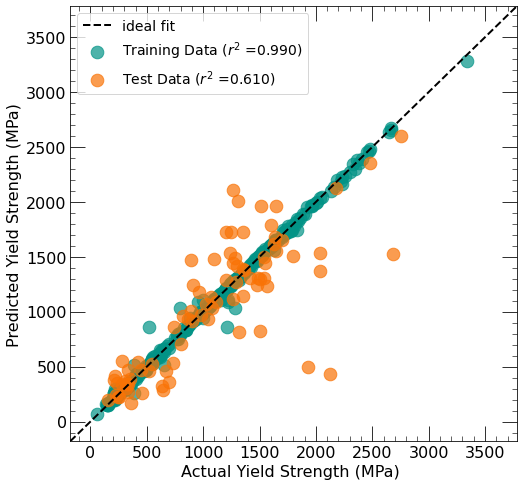

In [7]:
plot_model_performance(y_train,y_train_predict,y_test,y_test_predict,r2_train=0.99,r2_test=0.61)

## Random Forest Regressor CV 

In [8]:
##### Random forest regressor with Grid search ############################
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
base_model = RandomForestRegressor(random_state=rng_seed, criterion='mse')

param_grid = { 'n_estimators' : [50,100,200],
                'max_depth': [3,4,5,6,7],
                'max_features': [1, 'sqrt', 'log2'],
                'min_samples_split': [4,5,6,7],
                'min_samples_leaf':[3,4,5,6],
             }


rf_gs=GridSearchCV(base_model,param_grid,scoring='neg_mean_squared_error',cv=5)
rf_gs.fit(X_train_scaled,y_train)
print(rf_gs.best_estimator_)


rf_best = rf_gs.best_estimator_
print(rf_best)


y_train_predict=rf_best.predict(X_train_scaled)
y_test_predict=rf_best.predict(X_test_scaled)

print(model_evaluation_result(y_train,y_train_predict,y_test,y_test_predict,model='RF CV'))



RandomForestRegressor(criterion='mse', max_depth=7, max_features='sqrt',
                      min_samples_leaf=3, min_samples_split=4, n_estimators=50,
                      random_state=20)
RandomForestRegressor(criterion='mse', max_depth=7, max_features='sqrt',
                      min_samples_leaf=3, min_samples_split=4, n_estimators=50,
                      random_state=20)
              mae        rmse   r2score  model
Train  169.497087  243.870564  0.840832  RF CV
Test   249.546615  369.098463  0.633487  RF CV


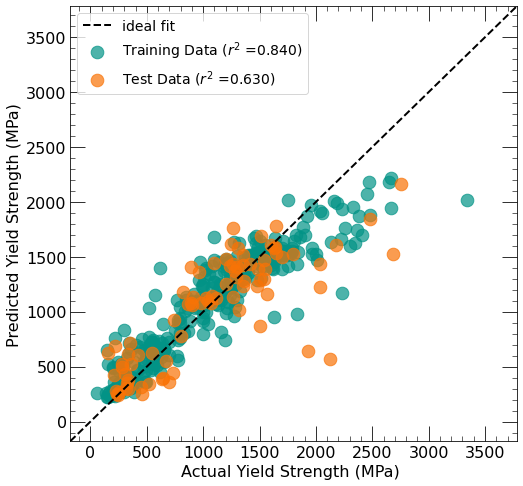

In [9]:
plot_model_performance(y_train,y_train_predict,y_test,y_test_predict,r2_train=0.84,r2_test=0.63)


## SVR CV

In [10]:
## SVR 
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
svr_params = {
    'C': [1,10,100,1000],
    "kernel":['linear','poly','rbf','sigmoid'],
    "epsilon":[0.001,0.01,0.1,1,10,100]
}

# C is the regularization penalty; 
# low value of C wider margin that is allowing soft margin 
# higher value of C narrow margin that is hard margin 

base_model = SVR(gamma='scale')



svr_gr=GridSearchCV(base_model,svr_params,scoring='neg_mean_squared_error',cv=5)



svr_gr.fit(X_train_scaled, y_train)

print(svr_gr.best_params_)
print("MSE:"+ str(-svr_gr.best_score_))

svr_best = svr_gr.best_estimator_
y_train_predict=svr_best.predict(X_train_scaled)
y_test_predict=svr_best.predict(X_test_scaled)

print(model_evaluation_result(y_train,y_train_predict,y_test,y_test_predict,model='SVR cv')) 


{'C': 1000, 'epsilon': 10, 'kernel': 'rbf'}
MSE:166922.77795307257
              mae        rmse   r2score   model
Train  228.943667  372.982975  0.627682  SVR cv
Test   288.689684  446.978387  0.462500  SVR cv


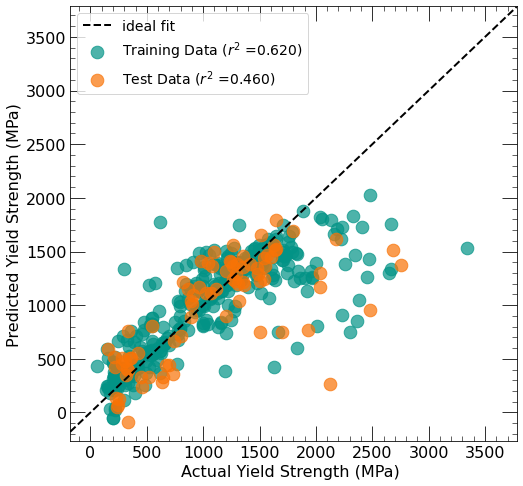

In [11]:
plot_model_performance(y_train,y_train_predict,y_test,y_test_predict,r2_train=0.62,r2_test=0.46)


## KNN  with CV

In [12]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

KNN_params = {
    'n_neighbors': np.arange(2,16)
}

base_model = KNeighborsRegressor()


KNN_gr = GridSearchCV(base_model,KNN_params,scoring='neg_mean_squared_error',cv=5)

KNN_gr.fit(X_train_scaled, y_train)

print(KNN_gr.best_params_)
#print(KNN_gr.cv_results_)

KNN_best = KNN_gr.best_estimator_

y_train_predict=KNN_best.predict(X_train_scaled)
y_test_predict=KNN_best.predict(X_test_scaled)
print(model_evaluation_result(y_train,y_train_predict,y_test,y_test_predict,model='SVR Default')) 



{'n_neighbors': 3}
              mae        rmse   r2score        model
Train  167.683543  254.391672  0.826802  SVR Default
Test   258.800040  404.868857  0.559005  SVR Default


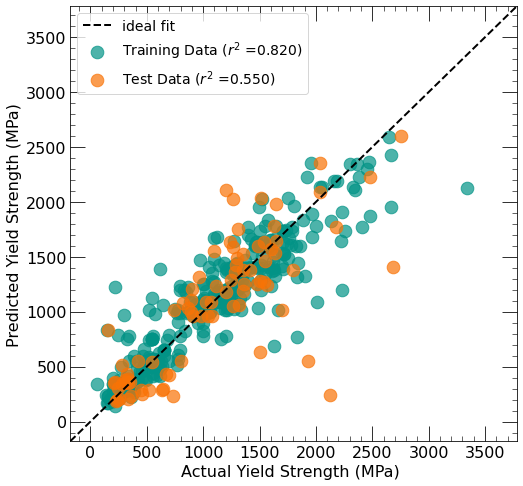

In [13]:
plot_model_performance(y_train,y_train_predict,y_test,y_test_predict,r2_train=0.82,r2_test=0.55)


## BOOTSTRAP ESTIMATOR 

In [14]:
def bootstrap_estimator(model, X_train, y_train, X_test, n_iter=1000):
    
    '''
    Function to estimate the mean and standard deviation
    
    
    '''

    
    bootstrap_preds = np.zeros([len(X_test), n_iter])
    
    index = np.arange(X_train.shape[0])
    
    ## set the seed to repeat the boot strapping 
    np.random.seed(20)
    for i in range(n_iter):
        #sample from X_train, y_train
        index_sampled = np.random.choice(index, size=X_train.shape[0], replace=True)

        X_train_sample = X_train[index_sampled,:]
        y_train_sample = y_train[index_sampled]
        
        #model.fit(X_train_sample, y_train_sample)
        model.fit(X_train_sample, y_train_sample)
        
        #pred_i = model.predict(X_test)
        
        pred_i = model.predict(X_test)
        #print('pred_i:', pred_i)
        
        bootstrap_preds[:,i] = pred_i
        #print(bootstrap_preds)
        
    return(bootstrap_preds.mean(1),bootstrap_preds.std(1))


In [15]:
mean_test , std_test  = bootstrap_estimator(gbr_gs_best, X_train_scaled, y_train, X_test_scaled, n_iter=1000)

#print(pd.DataFrame([mean_test,std_test]))

mean_train , std_train  = bootstrap_estimator(gbr_gs_best, X_train_scaled, y_train, X_train_scaled, n_iter=1000)


## Mean and Standard Deviation for Test data 

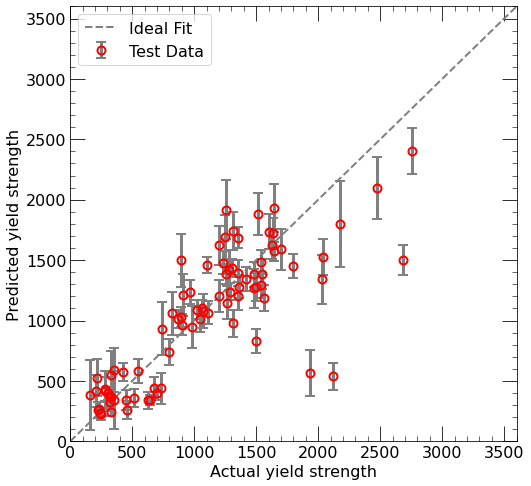

In [16]:
plt.figure(figsize=(8,8))

plt.errorbar(y_test,mean_test,yerr=std_test,ecolor = 'grey',mfc='None', mec='red',mew=2,elinewidth= 3,ls = 'none',marker='o',markersize=8,solid_capstyle='projecting', capsize=5,label='Test Data')

plt.xlabel('Actual yield strength',fontsize=16)
plt.ylabel('Predicted yield strength',fontsize=16)
plt.axline((0, 0), (1200, 1200), linewidth=2, color='grey',linestyle='dashed',label='Ideal Fit')
plt.legend(fontsize=16)
plt.xlim(0,3600)
plt.ylim(0,3600)

plt.minorticks_on()
plt.tick_params(labelsize=16)
plt.tick_params(direction='in',which='major', length=15, bottom=True, top=True, left=True, right=True,colors='k')
plt.tick_params(direction='in',which='minor', length=5, bottom=True, top=True, left=True, right=True,colors='k')


## Mean and Standard Deviation for Train data 

(0.0, 3600.0)

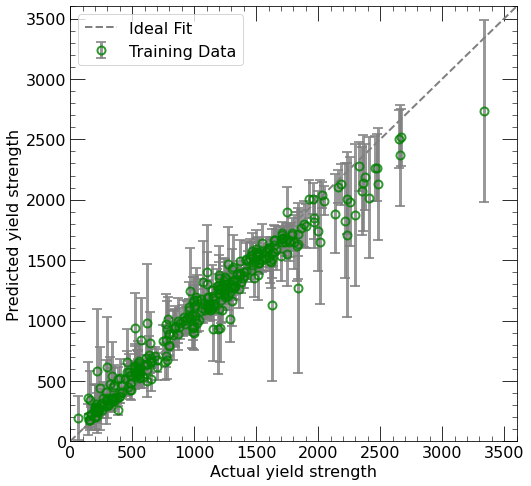

In [17]:
plt.figure(figsize=(8,8))

plt.errorbar(y_train,mean_train,yerr=std_train,mfc='None',mec='green',mew=2,ecolor = 'grey',alpha=0.8, elinewidth= 3,ls = 'none',marker='o',markersize=8,solid_capstyle='projecting', capsize=5,label='Training Data')
plt.xlabel('Actual yield strength',fontsize=16)
plt.ylabel('Predicted yield strength',fontsize=16)
plt.axline((0, 0), (1000, 1000), linewidth=2, color='grey',linestyle='dashed',label='Ideal Fit')
plt.legend(fontsize=16)

plt.minorticks_on()
plt.tick_params(labelsize=16)
plt.tick_params(direction='in',which='major', length=15, bottom=True, top=True, left=True, right=True,colors='k')
plt.tick_params(direction='in',which='minor', length=5, bottom=True, top=True, left=True, right=True,colors='k')


plt.xlim(0,3600)
plt.ylim(0,3600)